In [1]:
# $ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
# $ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기
# '/aiffel/lyricist/data/shakespeare.txt'

In [2]:
import re    
import glob
import numpy as np         
import tensorflow as tf    
import os
txt_file_path =os.getenv('HOME') +'/aiffel/lyricist/data/lyrics/*.txt'
txt_list = glob.glob(txt_file_path)
raw_corpus = []
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


데이터 다운로드

In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   
    if sentence[-1] == ":": continue  
    if idx >15: break   
    print(sentence)

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 
I just feel so good, so good 
But right now I just feel cold, so cold 
Right down to my bones 
'Cause ooh... 
Ain't no sunshine when she's gone 


가사 확인

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()   
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'      
    return sentence
print(preprocess_sentence("This @_is ;;;sample        sentence."))   

<start> this is sample sentence . <end>


In [5]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

In [6]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  
        filters=' ',    
        oov_token="<unk>" 
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
	
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  
    print(tensor,tokenizer)
    return tensor, tokenizer
tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f1f00570130>


In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [9]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [10]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


In [11]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [12]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 19
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
172/550 [========>.....................] - ETA: 3:22 - loss: 3.4177

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    return generated   

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)



시작부터 데이터 다운로드 부터 망한줄 알았지만 아니였던걸 깨닫고 행복해했던 그순간
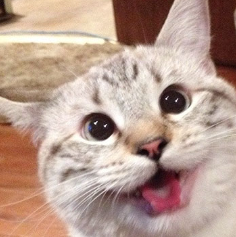
빵긋 웃었다 히히히히히
피곤하다 자러갑니다
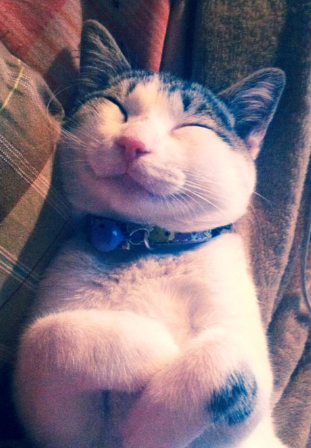
(오늘도 회고는 날먹이였따)
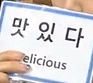